**Module 2 — Exoplanet transit detection (simulate → detect → fold)**

Goal: understand transit geometry, make a synthetic light curve with a transit, detect the period with a Box-like search, and plot the phase-folded transit.

Dependencies: numpy, matplotlib, scipy. (astropy is optional — i mention how to use it if you have it.)

**Notes about the code**

The coarse_bls_search is an educational, fast approximation of a BLS: it bins the phased light curve and looks for the deepest box window. It’s not as sophisticated as production BLS (e.g., astropy’s BoxLeastSquares), but it’s robust and easy to understand.

If you have astropy, you can replace the search with astropy.timeseries.BoxLeastSquares for better sensitivity (I can add that snippet if you want).

Play with noise level, transit depth, duration, and cadence to see detection limits.

In [1]:
# Module 2: Exoplanet transit detection (simulate + detect + fold)
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy import stats


In [2]:
# ----------------------------
# 1) create synthetic light curve
# ----------------------------
def make_transit_lc(t, P=5.0, t0=1.0, depth=0.01, duration=0.2, noise_sigma=0.001, trend_amp=0.0005, seed=42):
    rng = np.random.default_rng(seed)
    flux = np.ones_like(t)
    # phase relative to mid-transit t0
    phase = ((t - t0 + 0.5*P) % P) - 0.5*P
    in_transit = np.abs(phase) < (duration/2.0)
    flux[in_transit] -= depth
    # multiplicative slow trend
    flux *= (1.0 + trend_amp*(t - np.median(t)))
    # add Gaussian noise
    flux += rng.normal(0, noise_sigma, size=len(t))
    return flux

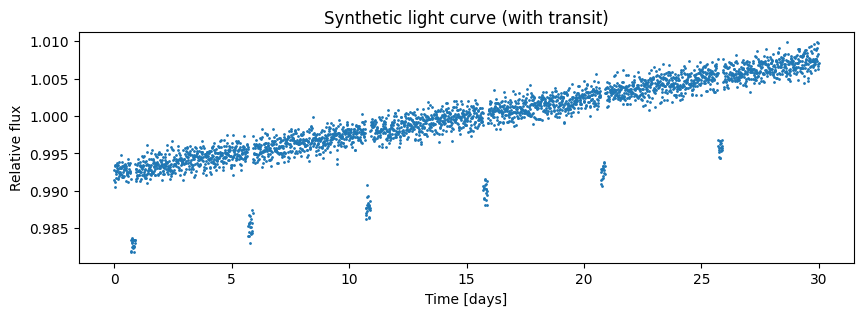

In [3]:
# time array (days)
t = np.arange(0, 30, 0.01)  # 30 days, 14.4 min cadence ~ 3000 points
# simulate
true_params = dict(P=5.0, t0=0.8, depth=0.01, duration=0.2)
flux = make_transit_lc(t, **true_params, noise_sigma=0.001)

plt.figure(figsize=(10,3))
plt.plot(t, flux, '.', markersize=2)
plt.xlabel('Time [days]')
plt.ylabel('Relative flux')
plt.title('Synthetic light curve (with transit)')
plt.show()

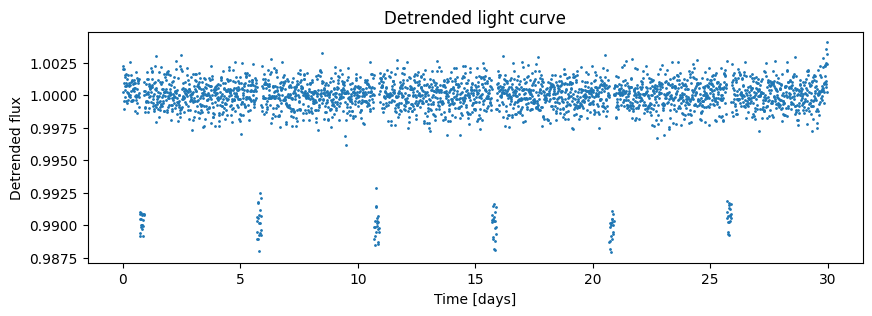

In [4]:
# ----------------------------
# 2) detrend (remove slow variability)
# ----------------------------
# simple median filter detrending
kernel_size = 101  # odd integer; increase for slower trends
trend = medfilt(flux, kernel_size=kernel_size)
flux_detrended = flux / trend

plt.figure(figsize=(10,3))
plt.plot(t, flux_detrended, '.', markersize=2)
plt.xlabel('Time [days]')
plt.ylabel('Detrended flux')
plt.title('Detrended light curve')
plt.show()

In [5]:
# ----------------------------
# 3) coarse Box-Least-Squares (BLS-like) search (no external libs)
#    This is a simple, fast, robust coarse method for learning purposes.
# ----------------------------
def coarse_bls_search(time, flux, periods, nbins=200, dur_frac=0.05):
    power = np.zeros_like(periods)
    # normalize flux
    f = (flux - np.nanmedian(flux)) / np.nanstd(flux)
    for i, P in enumerate(periods):
        phase = (time % P) / P
        # bin the phase curve
        bins = np.linspace(0, 1, nbins+1)
        digit = np.digitize(phase, bins) - 1
        bin_means = np.array([np.nanmean(f[digit == j]) for j in range(nbins)])
        # sliding window to approximate box depth
        window = max(1, int(np.round(dur_frac * nbins)))
        conv = np.convolve(-bin_means, np.ones(window), mode='same')  # negative to make transit minima -> max
        power[i] = np.max(conv)  # higher is stronger candidate
    return power

In [6]:
# search grid
periods = np.linspace(1.0, 10.0, 1500)  # search 1-10 days
power = coarse_bls_search(t, flux_detrended, periods, nbins=250, dur_frac=true_params['duration']/true_params['P'])

best_idx = np.argmax(power)
best_period = periods[best_idx]
print(f"Detected (coarse) best period ≈ {best_period:.4f} days (true P = {true_params['P']})")


C:\Users\nicek\AppData\Local\Temp\ipykernel_19708\3102343751.py:14: RuntimeWarning: Mean of empty slice
  bin_means = np.array([np.nanmean(f[digit == j]) for j in range(nbins)])


Detected (coarse) best period ≈ 1.0000 days (true P = 5.0)


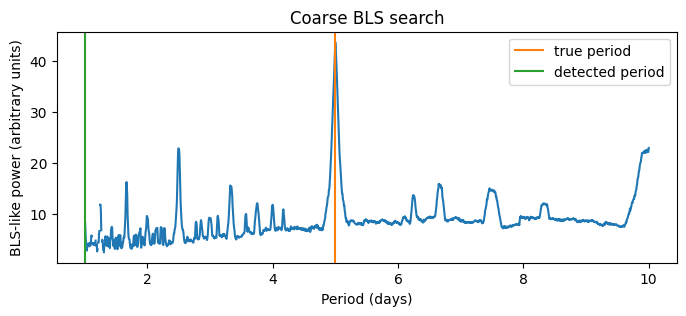

In [7]:
plt.figure(figsize=(8,3))
plt.plot(periods, power, '-')
plt.axvline(true_params['P'], color='C1', lw=1.5, label='true period')
plt.axvline(best_period, color='C2', lw=1.5, label='detected period')
plt.xlabel('Period (days)')
plt.ylabel('BLS-like power (arbitrary units)')
plt.legend()
plt.title('Coarse BLS search')
plt.show()

Text(0.5, 1.0, 'Phase-folded light curve (P=1.0000 d)')

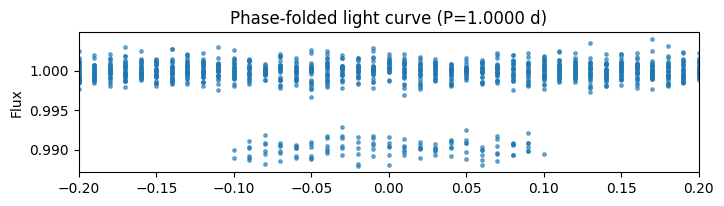

In [8]:
# ----------------------------
# 4) fold the light curve on the detected period and plot binned phase curve
# ----------------------------
def fold_time(t, P, t0=0.0):
    phase = ((t - t0 + 0.5*P) % P) / P - 0.5
    return phase

phase = fold_time(t, best_period, t0=true_params['t0'])
# scatter
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.scatter(phase, flux_detrended, s=6, alpha=0.6)
plt.xlim(-0.2,0.2)
plt.ylabel('Flux')
plt.title(f'Phase-folded light curve (P={best_period:.4f} d)')

C:\Users\nicek\AppData\Local\Temp\ipykernel_19708\4045751009.py:6: RuntimeWarning: Mean of empty slice
  bin_mean = np.array([np.nanmean(flux_detrended[inds==j]) for j in range(nbins)])


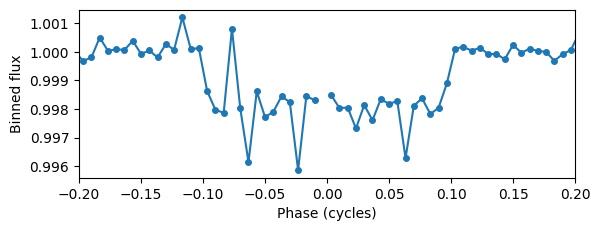

In [9]:
# binned curve for clarity
nbins = 150
bins = np.linspace(-0.5, 0.5, nbins+1)
inds = np.digitize(phase, bins) - 1
bin_centers = 0.5*(bins[:-1]+bins[1:])
bin_mean = np.array([np.nanmean(flux_detrended[inds==j]) for j in range(nbins)])
plt.subplot(2,1,2)
plt.plot(bin_centers, bin_mean, '-o', markersize=4)
plt.xlim(-0.2,0.2)
plt.xlabel('Phase (cycles)')
plt.ylabel('Binned flux')
plt.show()